# Préparation et nettoyage des données DVF

**Objectif** : préparer un jeu de données propre pour l'analyse des **locaux commerciaux / boutiques** à **Paris** (arrondissements, prix/m², année, géolocalisation).



In [2]:
import pandas as pd
import numpy as np
import os

In [3]:
df = pd.read_csv('dvf.csv')

C:\Users\victo\AppData\Local\Temp\ipykernel_25100\2023539279.py:1: DtypeWarning: Columns (8,10,12,14,16,17,18,20,22,24,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('dvf.csv')


##### on filtre les colonnes importantes

In [4]:
colonnes_importantes = [
    'date_mutation',
    'valeur_fonciere',
    'code_postal',
    'type_local',
    'surface_reelle_bati',
    'nombre_pieces_principales',
    'longitude',
    'latitude',
    'adresse_nom_voie',
    'nom_commune'
]

df = df[colonnes_importantes]

##### On enlève les lignes qui contiennent des valeurs NaN

In [5]:
df = df.dropna(subset=['valeur_fonciere', 'surface_reelle_bati', 
                       'nombre_pieces_principales',
                       'latitude', 'longitude'])

In [27]:
df.isna().sum()

date_mutation                 0
valeur_fonciere               0
code_postal                  79
type_local                    0
surface_reelle_bati           0
nombre_pieces_principales     0
longitude                     0
latitude                      0
adresse_nom_voie              4
nom_commune                   0
dtype: int64

##### On modifie le typage data en datetime

In [6]:
df['date_mutation'] = pd.to_datetime(df['date_mutation'], errors='coerce')

##### On ne retient que le type : "Local industriel. commercial ou assimilé"

In [7]:
type_autorise = ['Local industriel. commercial ou assimilé']
mask_type = df['type_local'].isin(type_autorise)
df = df[mask_type]

##### Puis on retire du dataframe la colonne "type_local"

In [8]:
df = df.drop('type_local', axis=1)

##### On s'intéresse uniquement au département de Paris

In [9]:
mask_paris = df['code_postal'].astype(str).str.startswith('75')
df = df[mask_paris]

##### Création d'une feature prix m²

In [10]:
df['prix_m2'] = df['valeur_fonciere'] / df['surface_reelle_bati']

##### On supprime les valeurs aberrantes au m²

In [11]:
df = df[(df['prix_m2'] > 500) & (df['prix_m2'] < 50000)]

##### Extraction de l'arrondissement (normalisation de code_postal)

In [12]:
df['code_postal'] = df['code_postal'].astype(int).astype(str).str.zfill(5)
df['arrondissement'] = pd.to_numeric(df['code_postal'].str[-2:], errors='coerce')
df.loc[~df['arrondissement'].between(1,20), 'arrondissement'] = np.nan
df['arrondissement'] = df['arrondissement'].dropna().astype(int)

##### on supprime la colonne code_postal (c'est toujours Paris)

In [13]:
df = df.drop('code_postal', axis=1)

##### Certains nom de communes ne sont pas Paris. On les supprime

In [14]:
cond_valides_villes = df['nom_commune'].str.startswith('Paris')
df = df[cond_valides_villes]

✅ Fichier chargé : dvf_paris_commerces_clean.csv
Lignes: 2998 | Colonnes: 15

Colonnes : ['date_mutation', 'valeur_fonciere', 'adresse_nom_voie', 'code_postal', 'code_commune', 'type_local', 'surface_reelle_bati', 'nombre_pieces_principales', 'longitude', 'latitude', 'prix_m2', 'arrondissement', 'annee', 'mois', 'trimestre']
  date_mutation  valeur_fonciere      adresse_nom_voie  code_postal  \
0    2024-01-08         170000.0           PAS BASFOUR        75002   
1    2024-01-04         650000.0           RUE JOUBERT        75009   
2    2024-01-10         500000.0      RUE DOUDEAUVILLE        75018   
3    2024-01-10         378000.0  RUE DU FBG DU TEMPLE        75010   
4    2024-01-10         378000.0  RUE DU FBG DU TEMPLE        75010   

   code_commune                                type_local  \
0         75102  Local industriel. commercial ou assimilé   
1         75109  Local industriel. commercial ou assimilé   
2         75118  Local industriel. commercial ou assimilé   
3 

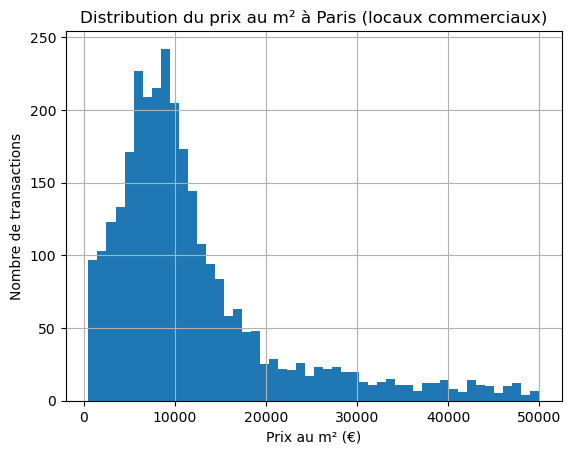

In [3]:

import matplotlib.pyplot as plt
# === CONFIGURATION ===
FILE_PATH = "dvf_paris_commerces_clean.csv"

# Seuils de détection
SMALL_SURFACE = 5       # m² (suspect si < 5)
LARGE_SURFACE = 5000    # m² (suspect si > 5000)
PRIX_M2_MIN = 200       # €/m²
PRIX_M2_MAX = 100000    # €/m²
IQR_MULT = 1.5          # multiplicateur IQR
Z_THRESH = 3.0          # z-score

# === CHARGEMENT ===
df = pd.read_csv(FILE_PATH)
print("✅ Fichier chargé :", FILE_PATH)
print(f"Lignes: {len(df)} | Colonnes: {len(df.columns)}")
print("\nColonnes :", list(df.columns))

print(df.head())
# === VALEURS MANQUANTES ===
print("\n--- Vérification des valeurs manquantes ---")
missing = df.isna().sum()
print(missing[missing > 0].sort_values(ascending=False) if missing.any() else "Aucune valeur manquante.")

# === DÉTECTION DE DOUBLONS ===
duplicates = df.duplicated().sum()
print(f"\n--- Doublons exacts ---\n{duplicates} doublons détectés.")

# === VALIDATION CODE POSTAL / ARRONDISSEMENT ===
if 'code_postal' in df.columns:
    bad_cp = df[~df['code_postal'].astype(str).str.match(r'75\d{2}', na=False)]
    print(f"\nCodes postaux non parisiens : {len(bad_cp)}")
if 'arrondissement' in df.columns:
    bad_arr = df[~df['arrondissement'].between(1, 20, inclusive="both")]
    print(f"Arrondissements invalides : {len(bad_arr)}")

# === SURFACE ===
if 'surface_reelle_bati' in df.columns:
    s = pd.to_numeric(df['surface_reelle_bati'], errors='coerce')
    print("\n--- Analyse des surfaces ---")
    print(f"Surfaces manquantes : {s.isna().sum()}")
    print(f"Surfaces < {SMALL_SURFACE} m² : {(s < SMALL_SURFACE).sum()}")
    print(f"Surfaces > {LARGE_SURFACE} m² : {(s > LARGE_SURFACE).sum()}")
    print(s.describe())

# === PRIX AU M² ===
if 'prix_m2' in df.columns:
    p = pd.to_numeric(df['prix_m2'], errors='coerce')
    print("\n--- Analyse du prix au m² ---")
    print(p.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]))
    print(f"prix_m2 < {PRIX_M2_MIN} : {(p < PRIX_M2_MIN).sum()}")
    print(f"prix_m2 > {PRIX_M2_MAX} : {(p > PRIX_M2_MAX).sum()}")

    # Détection des outliers
    q1, q3 = p.quantile([0.25, 0.75])
    iqr = q3 - q1
    low, high = q1 - IQR_MULT * iqr, q3 + IQR_MULT * iqr
    outliers_iqr = ((p < low) | (p > high)).sum()
    print(f"Outliers (IQR) : {outliers_iqr} (bornes {low:.1f} - {high:.1f})")

    z = (p - p.mean()) / p.std()
    outliers_z = (abs(z) > Z_THRESH).sum()
    print(f"Outliers (z-score > {Z_THRESH}) : {outliers_z}")

# === COORDONNÉES GÉOGRAPHIQUES ===
if 'latitude' in df.columns and 'longitude' in df.columns:
    lat = pd.to_numeric(df['latitude'], errors='coerce')
    lon = pd.to_numeric(df['longitude'], errors='coerce')
    print("\n--- Vérification des coordonnées géographiques ---")
    print(f"Coordonnées manquantes : {(lat.isna() | lon.isna()).sum()}")
    print(f"Latitude hors Paris (48.80–48.92) : {(~lat.between(48.80, 48.92)).sum()}")
    print(f"Longitude hors Paris (2.25–2.42) : {(~lon.between(2.25, 2.42)).sum()}")

print("\n✅ Analyse terminée.")


df['prix_m2'].hist(bins=50)
plt.title("Distribution du prix au m² à Paris (locaux commerciaux)")
plt.xlabel("Prix au m² (€)")
plt.ylabel("Nombre de transactions")
plt.show()